<a href="https://colab.research.google.com/github/saisrikanthrayavarapu/CNN/blob/main/ISIC_melanoma_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [ ]:
!mkdir "/content/CNN_assignment" # creating a new directory for the unzipped file
!gdown --id "1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs" # downloading the zipped file in the session
# https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
To: /content/CNN_assignment.zip
100% 824M/824M [00:04<00:00, 168MB/s]


In [ ]:
# unzipping the file in the created directory
!unzip -q "/content/CNN_assignment.zip" -d "/content/CNN_assignment" 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# listing all the files under content
!ls

CNN_assignment	CNN_assignment.zip  drive  sample_data


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train) 
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               validation_split=0.2, # using 20% of data for validation from the train dataset
                                                               subset='training') # The subset should be 'training' or 'validation'

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset='validation') # validation data set

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### code to visualize one instance of all the nine classes present in the dataset

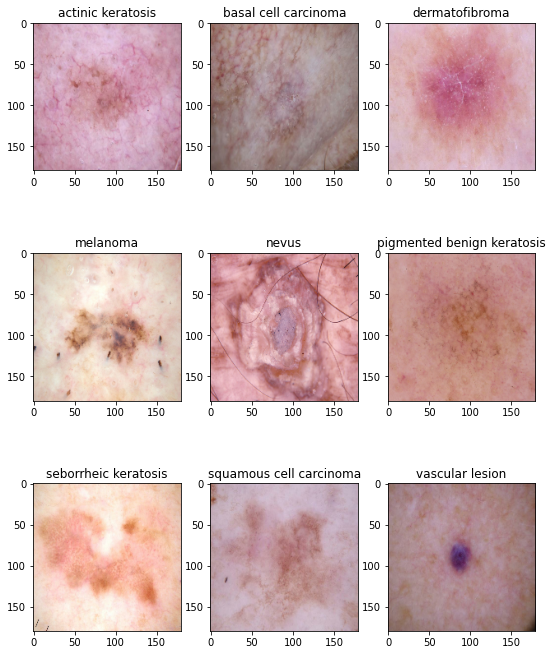

In [ ]:
### visualising trainvalidation data (sampling one image per class)
import matplotlib.pyplot as plt

plt.figure(figsize=(9,12))
for i in range(len(class_names)):
    filtered_data = val_ds.filter(lambda img, lbl: tf.math.equal(lbl[0], i))
    for image, label in filtered_data.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# AUTOTUNE helps in achieving better performance reducing CPU load
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### appling optimizer anf loss function on the created model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
# Training the intial model for 20 epochs
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 99ms/step - loss: 2.0040 - accuracy: 0.2388 - val_loss: 1.8147 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6276 - accuracy: 0.4107 - val_loss: 1.5940 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4407 - accuracy: 0.4961 - val_loss: 1.4612 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3042 - accuracy: 0.5441 - val_loss: 1.4000 - val_accuracy: 0.5503
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2216 - accuracy: 0.5837 - val_loss: 1.3441 - val_accuracy: 0.5593
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1410 - accuracy: 0.6044 - val_loss: 1.3997 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.0416 - accuracy: 0.6401 - val_loss: 1.3884 - val_accuracy: 0.5682
Epoch 8/20
5

### Visualizing training results

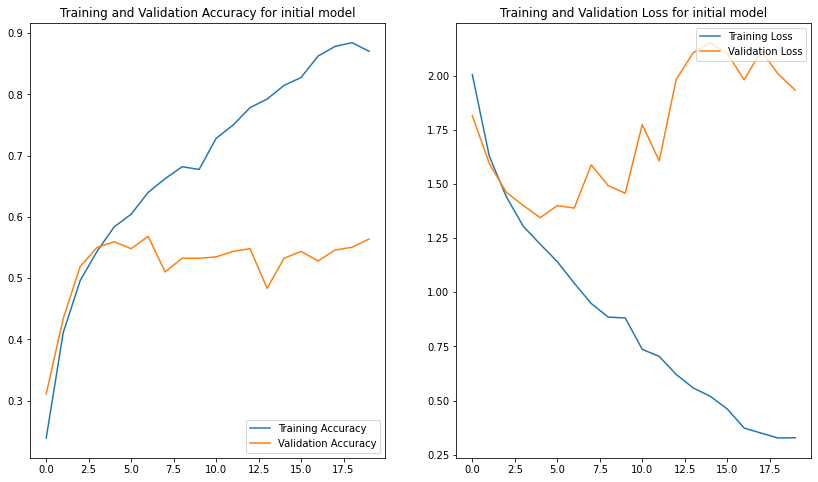

In [ ]:
# verifying the intial model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for initial model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for initial model')
plt.show()

#### see if there is an evidence of model overfit or underfit

### Findings from the above

- From the accuracy graph, the training accuracy steadily increases over each iteration whereas the validation accuracy did not catch up withthe training data
- Even the loss curves showed that the training set had loss in decreasing and the validation loss started to increase after 5th iteration
- Evidently we can confirm that the model is **overfitting**

In [ ]:
# analyse the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# performing augmentaion by rotating the images horizontally and vertically
augmented_df = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
]) # Creating augmented images on top of actual data to reduce overfitting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


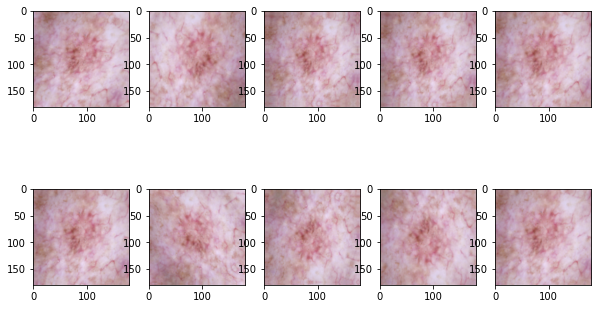

In [ ]:
# visualizing the working of augmentation strategy works for one instance of training image.
# augmentation by image rotation through manual augmentation
plt.figure(figsize=(10, 6))
for images, _ in train_ds.take(2):
    for i in range(10):
        augmented_images = augmented_df(images)
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
plt.show()

### Create the model, compile and train the model by adding Augmented layer 


In [ ]:
## Dropout layer if there is an evidence of overfitting in your findings
# creating a model using the manual aumented dataframe
model_aug = Sequential([
  augmented_df,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

### Compiling the model

In [ ]:
# compiling the model with augmented layer
model_aug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# summary of the augmented model
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [ ]:
# training the augmented layer model for 20 epochs
epochs = 20
history_aug = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 5s 57ms/step - loss: 1.9935 - accuracy: 0.2550 - val_loss: 1.7952 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6609 - accuracy: 0.4029 - val_loss: 1.5010 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5253 - accuracy: 0.4743 - val_loss: 1.6046 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4459 - accuracy: 0.4955 - val_loss: 1.4085 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3416 - accuracy: 0.5324 - val_loss: 1.3447 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3986 - accuracy: 0.5067 - val_loss: 1.5191 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3077 - accuracy: 0.5374 - val_loss: 1.3314 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

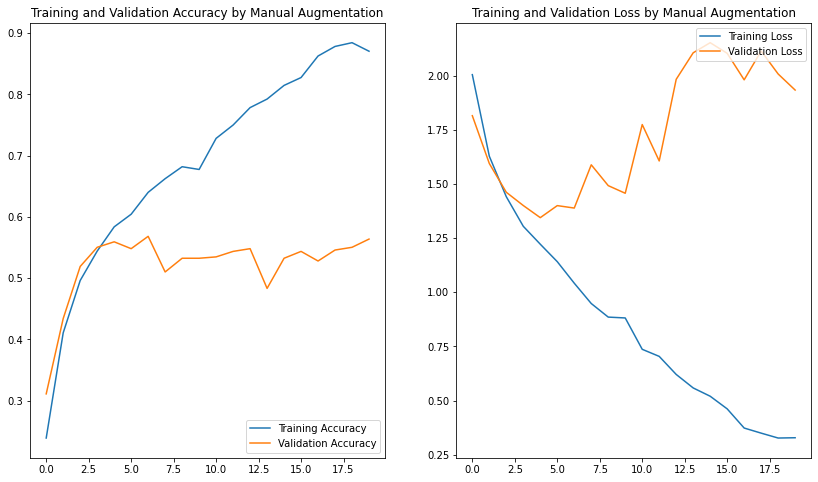

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy by Manual Augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss by Manual Augmentation')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
**A.** There is some improvement in variation as the train data is not memorized by the model thus reducing the difference between train accuracy and validation accuracy. THough the accuracy of the model is reduced

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# creating a dataframe from the actual data
path_list=[]
lesion_list=[]
for i in class_names:   
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
actual_df_dict = dict(zip(path_list, lesion_list))
actual_df = pd.DataFrame(list(actual_df_dict.items()),columns = ['Path','Label'])
actual_df.sample(n=10)

,Path,Label
980,/content/CNN_assignment/Skin cancer ISIC The I...,melanoma
2050,/content/CNN_assignment/Skin cancer ISIC The I...,squamous cell carcinoma
1138,/content/CNN_assignment/Skin cancer ISIC The I...,nevus
1525,/content/CNN_assignment/Skin cancer ISIC The I...,pigmented benign keratosis
829,/content/CNN_assignment/Skin cancer ISIC The I...,melanoma
1487,/content/CNN_assignment/Skin cancer ISIC The I...,pigmented benign keratosis
635,/content/CNN_assignment/Skin cancer ISIC The I...,melanoma
50,/content/CNN_assignment/Skin cancer ISIC The I...,actinic keratosis
1073,/content/CNN_assignment/Skin cancer ISIC The I...,nevus
1539,/content/CNN_assignment/Skin cancer ISIC The I...,pigmented benign keratosis


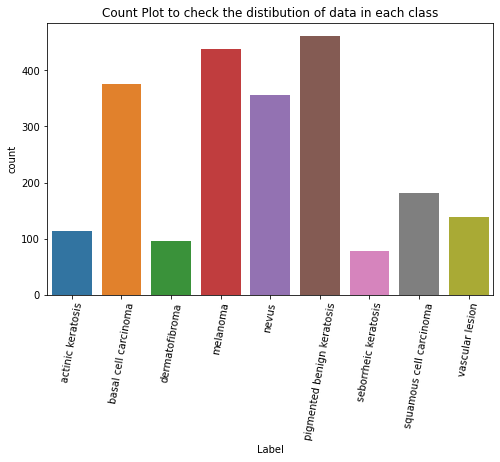

In [ ]:
import seaborn as sns
# Verifying data distribution among all the classes
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data = actual_df)
plt.title('Count Plot to check the distibution of data in each class')
plt.xticks(rotation=80)
plt.show()

In [ ]:
# class imbalance check
actual_df['Label'].value_counts(normalize=True)*100

pigmented benign keratosis    20.634212
melanoma                      19.562305
basal cell carcinoma          16.793211
nevus                         15.944618
squamous cell carcinoma        8.083966
vascular lesion                6.208129
actinic keratosis              5.091559
dermatofibroma                 4.242966
seborrheic keratosis           3.439035
Name: Label, dtype: float64

#### - Which class has the least number of samples?
<b>A.</b> `seborrheic keratosis` has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
<b>A.</b> `pigmented benign keratosis`, `melanoma`, `basal cell carcinoma` and `nevus` contain around 70% of the data


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# installing Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# Augmentor sets a pipeline to create definitive number of augmented image sets per class
path_to_training_dataset="/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD9EB88CD0>: 100%|██████████| 500/500 [00:20<00:00, 24.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD225D7150>: 100%|██████████| 500/500 [00:20<00:00, 24.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDD22591990>: 100%|██████████| 500/500 [00:20<00:00, 23.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDD221E9750>: 100%|██████████| 500/500 [01:46<00:00,  4.69 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FDD22259610>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDD221E9D50>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDD2225A690>: 100%|██████████| 500/500 [00:50<00:00,  9.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD261A17D0>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD2233C950>: 100%|██████████| 500/500 [00:21<00:00, 23.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# All the Augmented images created by Augmentor are added under a seperate output folder under each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train) # 500 images per class are added which makes the added image count to 4500

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# pd.DataFrame({'Path':path_list_new}, index=None).head()

In [ ]:
label_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# pd.DataFrame({'Label':lesion_list_new},index=None).head()

In [ ]:
# creating a new dataframe to verify the images with respect to classes
dataframe_dict_new = dict(zip(path_list_new, label_list_new))

In [ ]:
# Adding all additional image data to the actual dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = actual_df.append(df2)
new_df.sample(n=10)

,Path,Label
1110,/content/CNN_assignment/Skin cancer ISIC The I...,nevus
3781,/content/CNN_assignment/Skin cancer ISIC The I...,basal cell carcinoma
1699,/content/CNN_assignment/Skin cancer ISIC The I...,dermatofibroma
1390,/content/CNN_assignment/Skin cancer ISIC The I...,vascular lesion
2029,/content/CNN_assignment/Skin cancer ISIC The I...,squamous cell carcinoma
576,/content/CNN_assignment/Skin cancer ISIC The I...,melanoma
2882,/content/CNN_assignment/Skin cancer ISIC The I...,squamous cell carcinoma
303,/content/CNN_assignment/Skin cancer ISIC The I...,basal cell carcinoma
357,/content/CNN_assignment/Skin cancer ISIC The I...,seborrheic keratosis
4211,/content/CNN_assignment/Skin cancer ISIC The I...,actinic keratosis


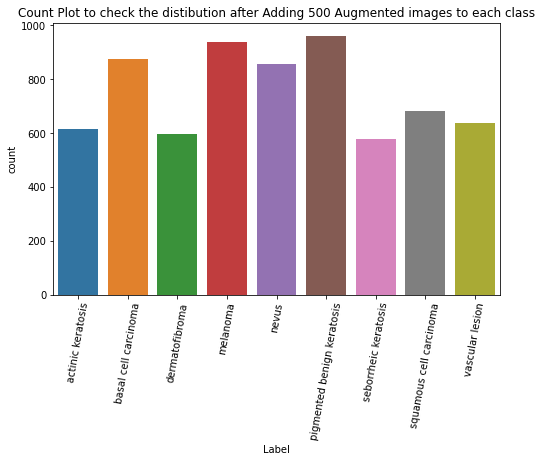

In [ ]:
# Verifying the distribution of data after adding 500 images to each class
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data = new_df)
plt.title('Count Plot to check the distibution after Adding 500 Augmented images to each class')
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Data imbalance is reduced after adding 500 images per class
new_df['Label'].value_counts(normalize=True)*100

pigmented benign keratosis    14.275115
melanoma                      13.918979
basal cell carcinoma          12.998961
nevus                         12.717020
squamous cell carcinoma       10.105357
vascular lesion                9.482119
actinic keratosis              9.111144
dermatofibroma                 8.829203
seborrheic keratosis           8.562101
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset using Augmentor

In [ ]:
# Creating the new dataset post augmentor implementation for train data (It is observed that the data size is increased)
data_dir_train="/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset using Augmentor

In [ ]:
# validation dataset for augmentor data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split = 0.2,
                                                             subset = 'validation',
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model for Augmentor data(added and normalised)

In [ ]:
# optimizinf the data for faster execution
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# creating model with added data using Augmentor
model_Augmentor = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

#### Compile the Augmentor model (with appropriate optimizer and loss function)

In [ ]:
# compiling the Augmentor model
model_Augmentor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the Augmentor model

In [ ]:
# training the augmentor model for 30 epochs
epochs = 30
history_Augmentor = model_Augmentor.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 34s 76ms/step - loss: 1.9401 - accuracy: 0.2606 - val_loss: 1.5596 - val_accuracy: 0.4246
Epoch 2/30
169/169 [==============================] - 7s 42ms/step - loss: 1.4512 - accuracy: 0.4503 - val_loss: 1.3878 - val_accuracy: 0.4944
Epoch 3/30
169/169 [==============================] - 7s 42ms/step - loss: 1.2457 - accuracy: 0.5378 - val_loss: 1.1957 - val_accuracy: 0.5568
Epoch 4/30
169/169 [==============================] - 7s 42ms/step - loss: 1.0590 - accuracy: 0.6124 - val_loss: 1.0332 - val_accuracy: 0.6244
Epoch 5/30
169/169 [==============================] - 7s 42ms/step - loss: 0.8563 - accuracy: 0.6860 - val_loss: 0.8953 - val_accuracy: 0.6897
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 0.6882 - accuracy: 0.7535 - val_loss: 0.8292 - val_accuracy: 0.7090
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 0.5487 - accuracy: 0.8103 - val_loss: 0.8076 - val_accuracy: 0.7313
Epoch 8/3

#### Visualize the model results for Augmentor model

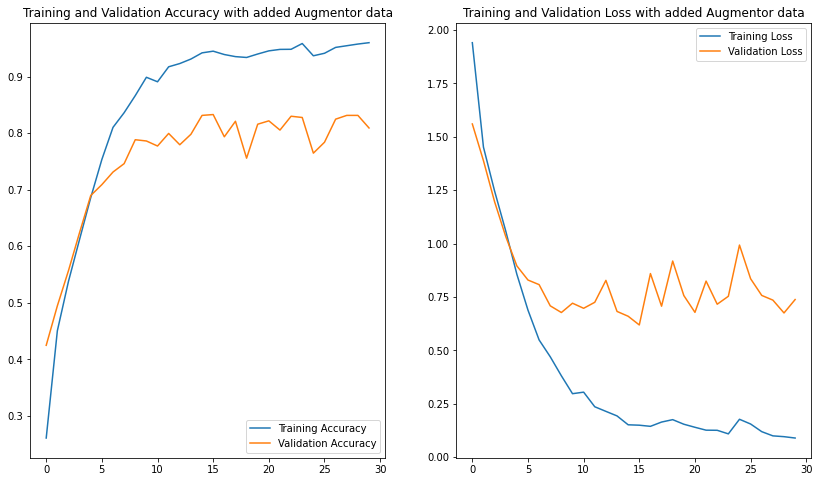

In [ ]:
acc = history_Augmentor.history['accuracy']
val_acc = history_Augmentor.history['val_accuracy']

loss = history_Augmentor.history['loss']
val_loss = history_Augmentor.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with added Augmentor data')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss with added Augmentor data')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- With Added data the class imbalance is highly reduced
- Model with added data using augmentor has certain amount of overfitting which can be brought down by adding more data
- Model with Data Augmentation layer was only helpful in reducing overfitting to some extend which also effected the model accuracy